# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
  1
 -1
  1
  1
  1
  1
  1
 -1
  ⋮
 -1
  1
  1
 -1
  1
  1
 -1
  1
  1

### We create a function to visualize the data

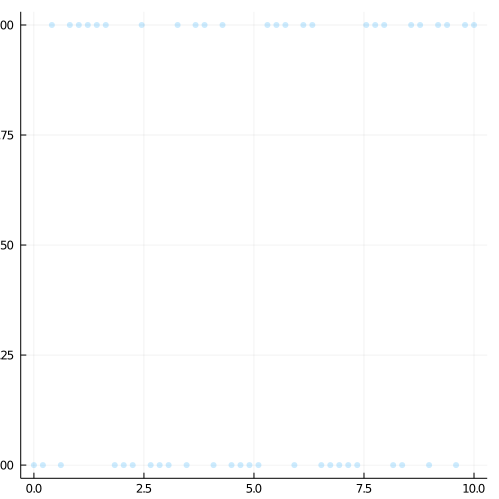

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.114389 seconds (1.87 M allocations: 106.880 MiB, 99.62% compilation time)


(Variational Gaussian Process with a Bernoulli Likelihood with Logistic Link infered by Analytic Variational Inference , (local_vars = (c = [0.7418726219829519, 0.6812580169909533, 0.6565634475546855, 0.6708913724816938, 0.7032057622929149, 0.7245091673524152, 0.7164367738969111, 0.6788490717912388, 0.6304465465688335, 0.6013314069609891  …  0.6116459490063859, 0.6414946624277427, 0.6810865621339491, 0.7232531564938459, 0.7638483578204578, 0.8014146004721611, 0.8355210148177749, 0.8664025184795877, 0.8944391962718291, 0.9193468636374243], θ = [0.23913163264336607, 0.24075961208606564, 0.2413902163258475, 0.24102668524908322, 0.24018311050971833, 0.2396093802235658, 0.23982840439532724, 0.2408219743636175, 0.24203591756674347, 0.24272946724812847  …  0.24248697151148904, 0.24176546116200376, 0.2407640566852416, 0.23964358826815363, 0.2385141871602837, 0.23742641627114872, 0.23640464900543365, 0.2354524388013695, 0.23456643839378358, 0.2337627009739626]), opt_state = (NamedTuple(),), hyp

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:15
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:10
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:06
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:34
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:15
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:02
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:46
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:41
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.9637141782438944, -0.5695504245676141, -0.14018912004493317, 0.15889313426291368, 0.3459520807536943, 0.38515300761222404, 0.28993244578785937, 0.0733140048891294, -0.2239155172063442, -0.5687590809747978  …  -0.030903373760611655, -0.12115918582168828, -0.21559756471671776, -0.338106801482837, -0.42031576830289785, -0.41225468575614044, -0.33095694871677334, -0.16392890721193293, 0.01533966378328988, 0.1914938429803802]]
 [[0.31297457638477233, 0.665429283999687, 0.9517212098684388, 1.137911293494287, 1.198568936868761, 1.1656991380185588, 1.0148044730320307, 0.8260872820000772, 0.5999256934474397, 0.42697793993303823  …  0.19616988578079267, 0.22266417459415, 0.15472608094544799, 0.10183829648366377, 0.00101561147667939, -0.08108592299526773, -0.11003465669489731, -0.07190303629675626, 0.006131188957895328, 0.10105844516449025]]
 [[1.6435568945570491, 1.4163115495113991, 1.097829214263431, 0.72915615278538, 0.3975303014328222, 0.117

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

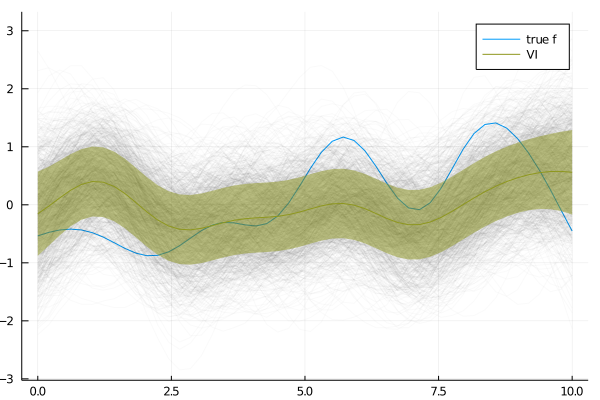

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

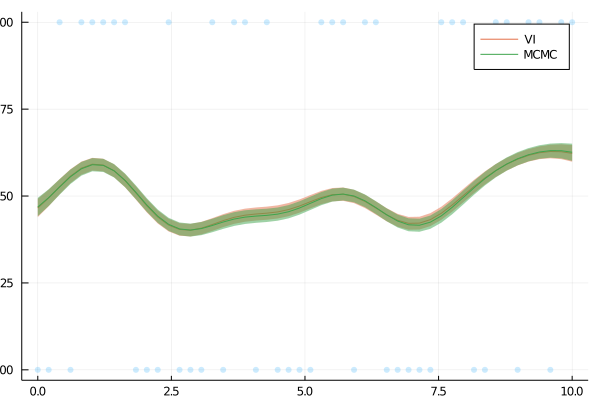

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*